<a href="https://colab.research.google.com/github/aaronjoseph/siim-covid19-detection/blob/master/EDA_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo pip install --upgrade --force-reinstall --no-deps "kaggle>=1.5.12"
!apt-get install -y fuse-zip
!pip install pydicom

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fuse-zip is already the newest version (0.4.4-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"aaronjoseph","key":"1fa60446a1bf44f239d2ca4ddda1d9f4"}

api_key = "9d9646b4fe5cfedcb7609d8f0773846848ecbcae"
!wandb login $api_key

import json
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob
import os
import re
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pprint
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
import cv2
!pip install wandb
import wandb
from zipfile import ZipFile
import zipfile
from PIL import Image
!pip install colorama
from colorama import Fore,Back,Style
# colored output
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sns.set(font="Serif",style ="white")

In [4]:
# Downloading the Data
!kaggle competitions download -c siim-covid19-detection -p /content/Input

100% 83.2G/83.2G [16:52<00:00, 80.8MB/s]
100% 83.2G/83.2G [16:52<00:00, 88.2MB/s]


In [5]:
# Using fuse-zip
input_dir = "/content/Input/siim"
!mkdir {input_dir}
!fuse-zip /content/Input/siim-covid19-detection.zip {input_dir}

In [4]:
train_image_level = pd.read_csv("/content/Input/siim/train_image_level.csv")
train_study_level = pd.read_csv("/content/Input/siim/train_study_level.csv")

In [5]:
train_image_level.head()

id  ... StudyInstanceUID
0  000a312787f2_image  ...     5776db0cec75
1  000c3a3f293f_image  ...     ff0879eb20ed
2  0012ff7358bc_image  ...     9d514ce429a7
3  001398f4ff4f_image  ...     28dddc8559b2
4  001bd15d1891_image  ...     dfd9fdd85a3e

[5 rows x 4 columns]

In [6]:
train_study_level.head()

id  ...  Atypical Appearance
0  00086460a852_study  ...                    0
1  000c9c05fd14_study  ...                    1
2  00292f8c37bd_study  ...                    0
3  005057b3f880_study  ...                    0
4  0051d9b12e72_study  ...                    1

[5 rows x 5 columns]

In [7]:
train_directory = "/content/Input/siim/train/"
test_directory = "/content/Input/siim/test/"
train_study_level['StudyInstanceUID'] = train_study_level['id'].apply(lambda x:x.replace('_study',''))
del train_study_level['id']
train_df = train_image_level.merge(train_study_level, on='StudyInstanceUID')

In [8]:
train_df.head()

id  ... Atypical Appearance
0  000a312787f2_image  ...                   0
1  000c3a3f293f_image  ...                   0
2  0012ff7358bc_image  ...                   0
3  001398f4ff4f_image  ...                   1
4  001bd15d1891_image  ...                   0

[5 rows x 8 columns]

In [9]:
training_paths = []

for sid in tqdm(train_df['StudyInstanceUID']):
    training_paths.append(glob.glob(os.path.join(train_directory, sid +"/*/*"))[0])
train_df['path'] = training_paths

100%|██████████| 6334/6334 [00:01<00:00, 4196.57it/s]


In [10]:
train_df.head()

id  ...                                               path
0  000a312787f2_image  ...  /content/Input/siim/train/5776db0cec75/81456c9...
1  000c3a3f293f_image  ...  /content/Input/siim/train/ff0879eb20ed/d8a644c...
2  0012ff7358bc_image  ...  /content/Input/siim/train/9d514ce429a7/22897cd...
3  001398f4ff4f_image  ...  /content/Input/siim/train/28dddc8559b2/4d47bc0...
4  001bd15d1891_image  ...  /content/Input/siim/train/dfd9fdd85a3e/49170af...

[5 rows x 9 columns]

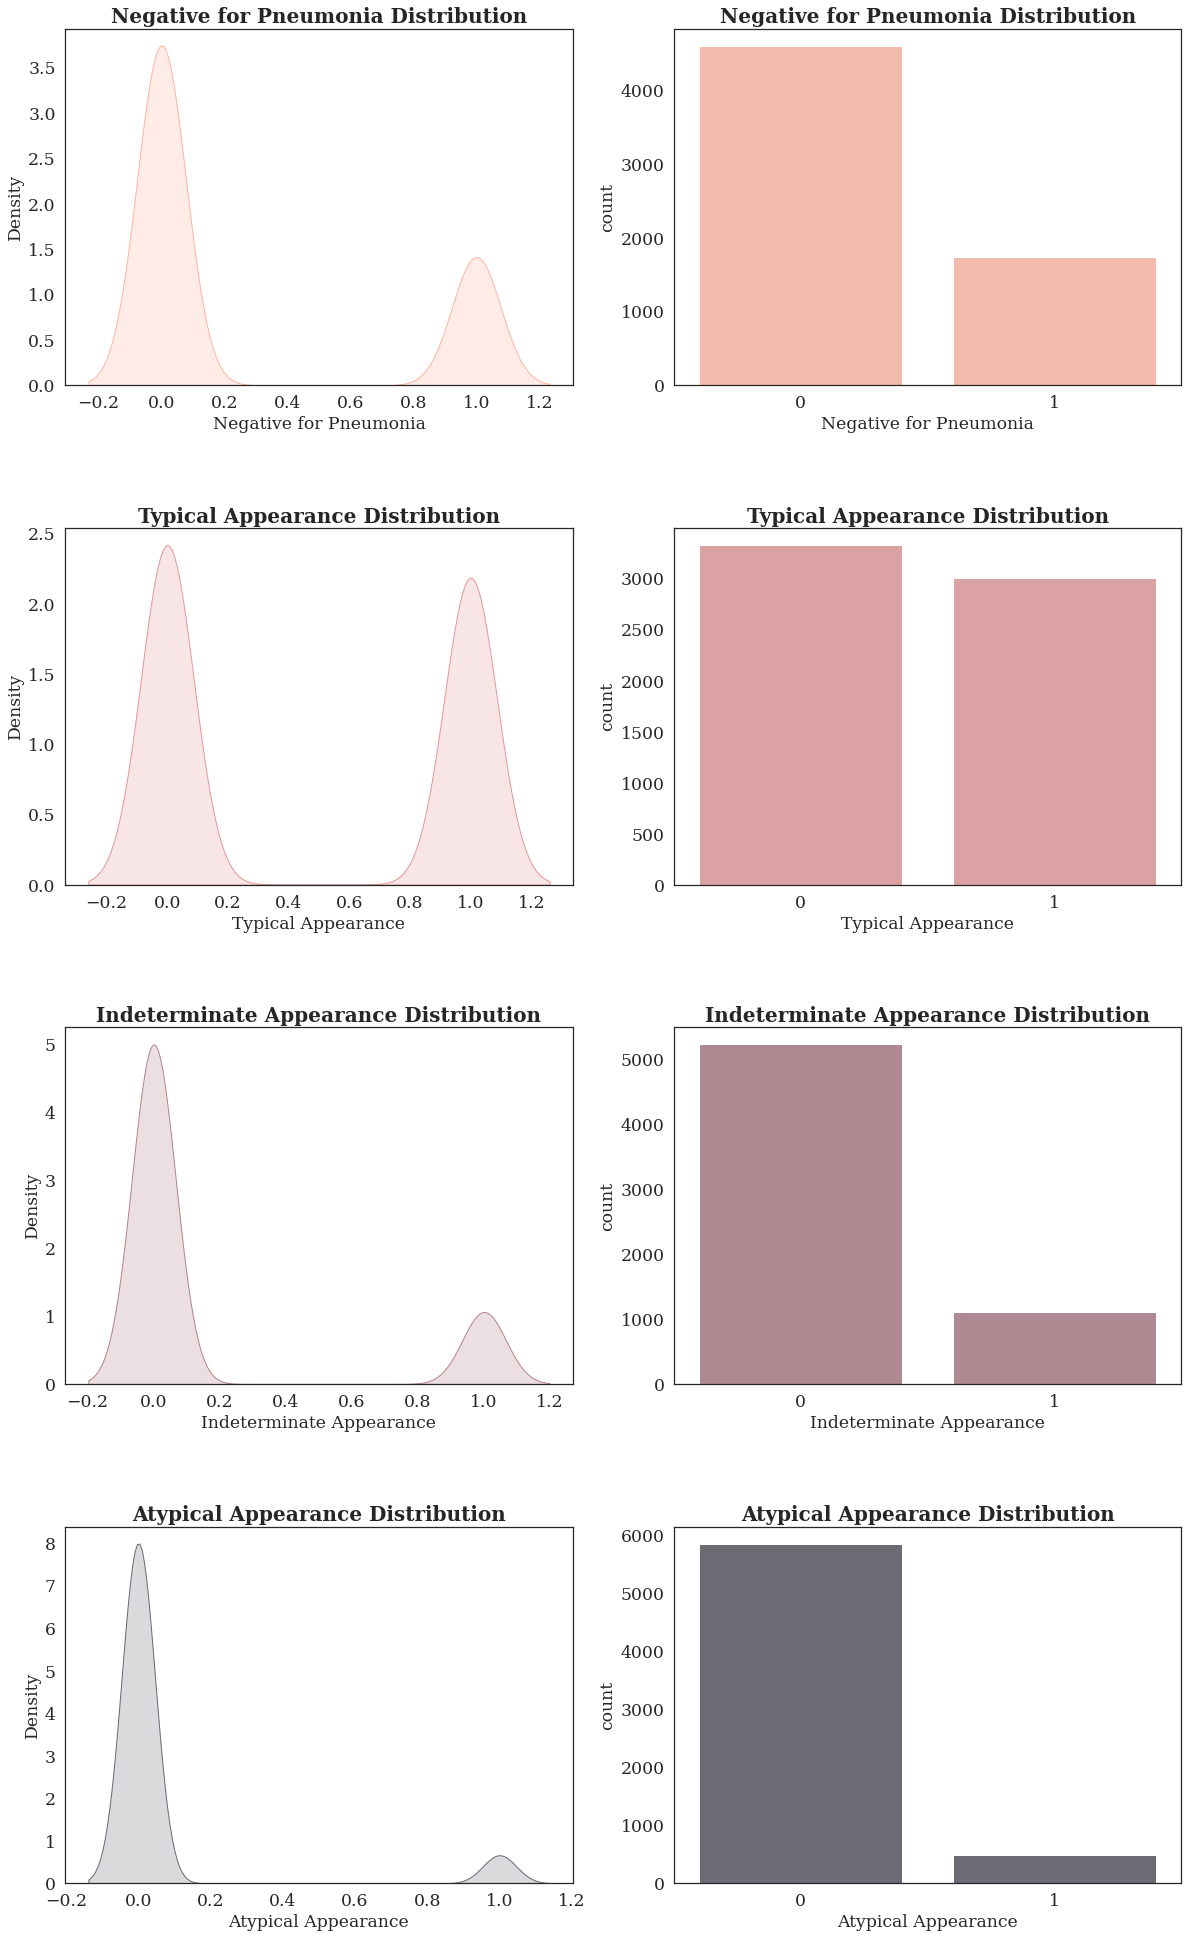

In [12]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 32),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(4,2)
sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
ax[0,0].set_title("Negative for Pneumonia Distribution",fontsize=20,weight="bold")
sns.countplot(x = train_df["Negative for Pneumonia"], ax=ax[0,1],color="#ffb4a2")
ax[0,1].set_title("Negative for Pneumonia Distribution",fontsize=20,weight="bold")

sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[1,0],color="#e5989b")
ax[1,0].set_title("Typical Appearance Distribution",fontsize=20,weight="bold")
sns.countplot(x = train_df["Typical Appearance"], ax=ax[1,1],color="#e5989b")
ax[1,1].set_title("Typical Appearance Distribution",fontsize=20,weight="bold")

sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[2,0],color="#b5838d")
ax[2,0].set_title("Indeterminate Appearance Distribution",fontsize=20,weight="bold")
sns.countplot(x = train_df["Indeterminate Appearance"], ax=ax[2,1],color="#b5838d")
ax[2,1].set_title("Indeterminate Appearance Distribution",fontsize=20,weight="bold")

sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[3,0],color="#6d6875")
ax[3,0].set_title("Atypical Appearance Distribution",fontsize=20,weight="bold")
sns.countplot(x = train_df["Atypical Appearance"], ax=ax[3,1],color="#6d6875")
ax[3,1].set_title("Atypical Appearance Distribution",fontsize=20,weight="bold")

fig.subplots_adjust(wspace=0.2, hspace=0.4, top=0.93)
plt.show()

In [16]:
#====== Function to plot WandB bar chart ======
def plot_wb_bar(df,col1,col2): 
    run = wandb.init(project='siim', job_type='image-visualization',name=col1)
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])] 
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({col1 : wandb.plot.bar(table, col1,col2,title=col1)})
    run.finish()
    
#====== Function to create a dataframe of value counts ======
def count_values(df,col):
    df = pd.DataFrame(df[col].value_counts().reset_index().values,columns=[col, "counts"])
    return df

plot_wb_bar(count_values(train_df,"Negative for Pneumonia"),"Negative for Pneumonia", 'counts')
plot_wb_bar(count_values(train_df,"Typical Appearance"),"Typical Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Indeterminate Appearance"),"Indeterminate Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Atypical Appearance"),"Atypical Appearance", 'counts')

In [39]:
# Dicom Data
voi_lut = True
fix_monochrome = True

def dicom_dataset_to_dict(filename,func):
    """Credit: https://github.com/pydicom/pydicom/issues/319
               https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    """
    dicom_header = dicom.dcmread(filename) 
    
    #====== DICOM FILE DATA ======
    dicom_dict = {}
    repr(dicom_header)
    for dicom_value in dicom_header.values():
        if dicom_value.tag == (0x7fe0, 0x0010):
            #discard pixel data
            continue
        if type(dicom_value.value) == dicom.dataset.Dataset:
            dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
        else:
            v = _convert_value(dicom_value.value)
            dicom_dict[dicom_value.name] = v
    del dicom_dict['Pixel Representation']
    
    if func!='metadata_df':
        #====== DICOM IMAGE DATA ======
        # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
        else:
            data = dicom_header.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom_header.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        modified_image_data = (data * 255).astype(np.uint8)
        return dicom_dict, modified_image_data
    else:
        return dicom_dict

def _sanitise_unicode(s):
    return s.replace(u"\u0000", "").strip()

def _convert_value(v):
    t = type(v)
    if t in (list, int, float):
        cv = v
    elif t == str:
        cv = _sanitise_unicode(v)
    elif t == bytes:
        s = v.decode('ascii', 'replace')
        cv = _sanitise_unicode(s)
    elif t == dicom.valuerep.DSfloat:
        cv = float(v)
    elif t == dicom.valuerep.IS:
        cv = int(v)
    else:
        cv = repr(v)
    return cv

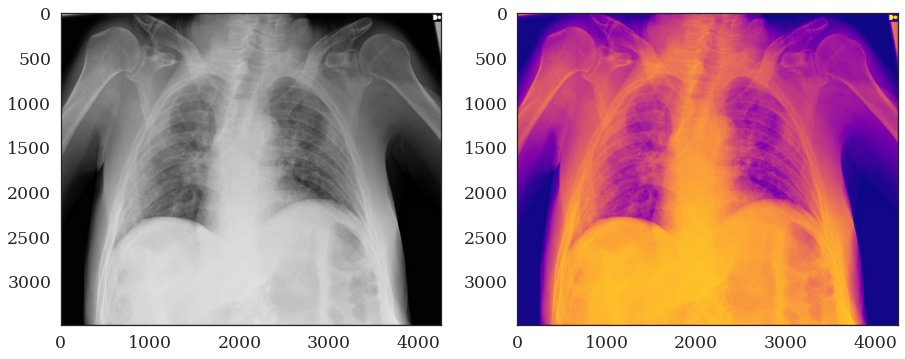

{'Accession Number': 'f6cd7f2019f5',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4256,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': 'dcc3fdf6426a',
 "Patient's Name": "'d4268f26ed05'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 3488,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'000a312787f2'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'81456c9c5423'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '526316e376d4',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'5776db0cec75'",
 'Study Time': '8ccfb6acf07f'}


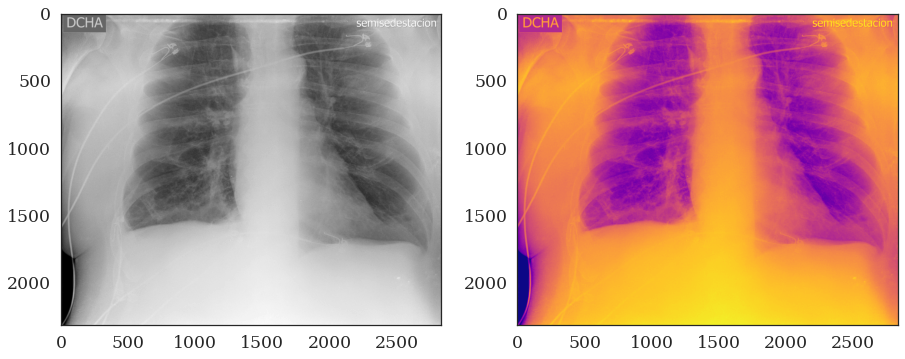

{'Accession Number': '1c2708371bc6',
 'Bits Allocated': 8,
 'Bits Stored': 8,
 'Body Part Examined': 'CHEST',
 'Columns': 2832,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 7,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.15, 0.15]',
 'Instance Number': 1,
 'Modality': 'CR',
 'Patient ID': 'f09ff9b7dab3',
 "Patient's Name": "'ef8c31f8dfdd'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2320,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'000c3a3f293f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'d8a644cc4f93'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'd09eda152722',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'ff0879eb20ed'",
 'Study Time': '543adb46f494'}


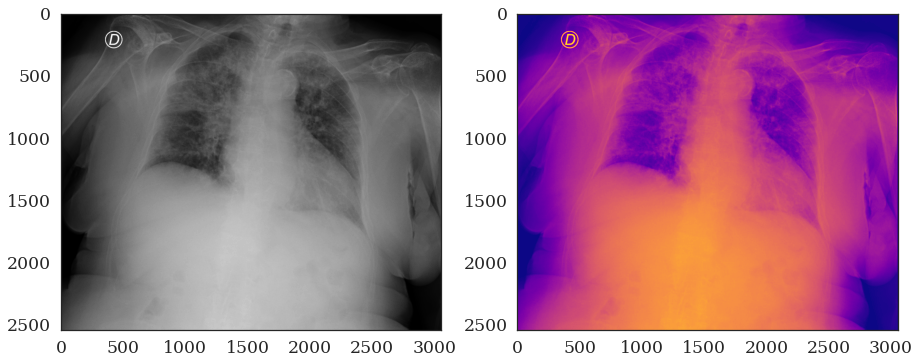

{'Accession Number': '99428f65d948',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'PORT CHEST',
 'Columns': 3056,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.139, 0.139]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '6a02c0731039',
 "Patient's Name": "'2f2fb944fe44'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2544,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'0012ff7358bc'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'22897cd1daa0'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '96fc21dd2b1f',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'9d514ce429a7'",
 'Study Time': '746186a2bbf2'}


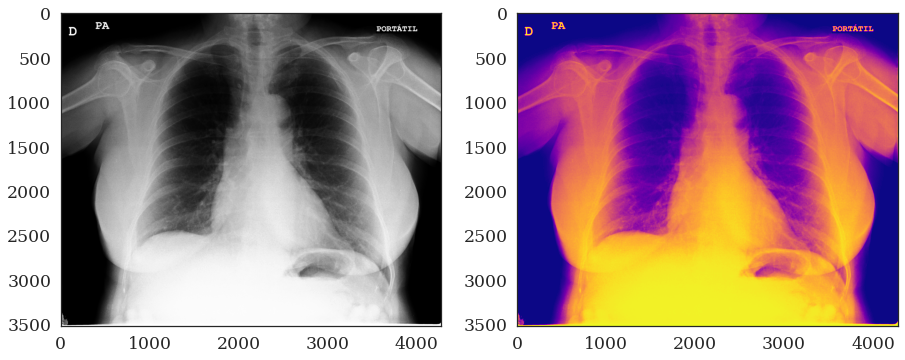

{'Accession Number': '7b889627faf1',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4280,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', "
               "'100000']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1002,
 'Modality': 'CR',
 'Patient ID': 'db63d9b7f61c',
 "Patient's Name": "'9ccd87b4511b'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME1',
 'Private Creator': 'GEIIS',
 'Rows': 3520,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'001398f4ff4f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'4d47bc042ee6'",
 'Series Number': 1002,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '3f094e1700ec',
 'Study ID': '55625fb42f3f',
 'Study Instance

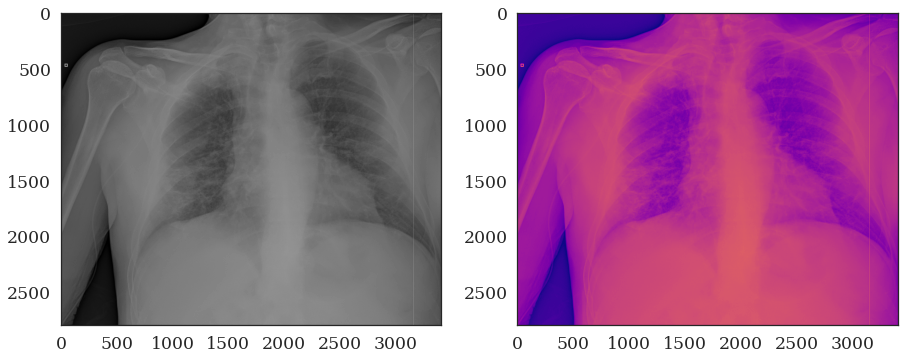

{'Accession Number': 'e9d93edf50c6',
 'Bits Allocated': 16,
 'Bits Stored': 15,
 'Body Part Examined': 'CHEST',
 'Columns': 3408,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 14,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.125, 0.125]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '605693f36f43',
 "Patient's Name": "'35bf9ddbf9e9'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME1',
 'Rows': 2800,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'001bd15d1891'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'49170afa4f27'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'a69d89c8a474',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'dfd9fdd85a3e'",
 'Study Time': '5399ff949226'}


In [ ]:
for filename in train_df.path[0:5]:
    df, img_array = dicom_dataset_to_dict(filename, 'fetch_both_values')
    fig, ax = plt.subplots(1, 2, figsize=[15, 8])
    ax[0].imshow(img_array, cmap=plt.cm.gray)
    ax[1].imshow(img_array, cmap=plt.cm.plasma)    
    plt.show()
    pprint.pprint(df)

In [17]:
dicom_data_list = []
for filename in train_df.path:
    try:
        data_di = dicom_dataset_to_dict(filename,'metadata')
        dicom_data_list.append(data_di)
    except:
        continue
        
dicom_data_df = pd.DataFrame(dicom_data_list)
dicom_data_df

Empty DataFrame
Columns: []
Index: []

In [18]:
dicom_data_list = []
for filename in train_df.path:
    try:
        data_di = dicom_dataset_to_dict(filename,'metadata_df')
        dicom_data_list.append(data_di)
    except:
        continue
dicom_data_df = pd.DataFrame(dicom_data_list) 

#====== Saving to csv files and creating artifacts ======
dicom_data_df.to_csv("dicom_metadata.csv")
run = wandb.init(project='siim', name='dicom_metadata')
artifact = wandb.Artifact('dicom_metadata', type='dataset')

#====== Add a file to the artifact's contents ======
artifact.add_file("dicom_metadata.csv")
#====== Save the artifact version to W&B and mark it as the output of this run ====== 
run.log_artifact(artifact)
run.finish()

In [41]:
dicom_data_list = []
for filename in train_df.path:
    try:
        data_di = dicom_dataset_to_dict(filename,'metadata_df')
        dicom_data_list.append(data_di)
    except:
        continue
dicom_data_df = pd.DataFrame(dicom_data_list) 
dicom_data_df

Specific Character Set  ... Private Creator
0                ISO_IR 100  ...             NaN
1                ISO_IR 100  ...             NaN
2                ISO_IR 100  ...             NaN
3                ISO_IR 100  ...           GEIIS
4                ISO_IR 100  ...             NaN
...                     ...  ...             ...
6329             ISO_IR 100  ...             NaN
6330             ISO_IR 100  ...             NaN
6331             ISO_IR 100  ...             NaN
6332             ISO_IR 100  ...             NaN
6333             ISO_IR 100  ...           GEIIS

[6334 rows x 28 columns]

In [ ]:
#====== Saving to csv files and creating artifacts ======
dicom_data_df.to_csv("dicom_metadata.csv")
run = wandb.init(job_type="dataset-creation")
artifact = wandb.Artifact('dicom_metadata', type='dataset')
#====== Add a file to the artifact's contents ======
artifact.add_file("dicom_metadata.csv")
#====== Save the artifact version to W&B and mark it as the output of this run ====== 
run.log_artifact(artifact)

In [45]:
# WandB plots
m = dicom_data_df.copy()
m = m.rename(columns={"Patient's Sex": "Patient Sex"})
cols_to_plot = ["Modality","Photometric Interpretation","Body Part Examined","Private Creator","De-identification Method","Patient Sex"]

for col in cols_to_plot:
    plot_wb_bar(count_values(m,col),col, 'counts')

In [46]:
# initializing the run
run = wandb.init(project="siim",
                 job_type="upload"
                 )

# creating an artifact
artifact = wandb.Artifact(name="dicom_metadata_image", type="raw_data")

# setting up a WandB Table object to hold the dataset
columns = ['image',"Body Part Examined","Image Type","Modality","Patient's Name","Patient ID","Patient's Sex","Study Instance UID"]
table = wandb.Table(
    columns=columns
)

for filename in train_df.path[0:5]:
    data_di, img_array = dicom_dataset_to_dict(filename,'fetch_both_values')
    
    body_part_examined = data_di.get("Body Part Examined")
    img_type = data_di.get('Image Type')
    modality = data_di.get("Modality")
    p_name = data_di.get("Patient's Name")
    p_id = data_di.get("Patient ID")
    p_gender = data_di.get("Patient's Sex")
    study_inst_uid = data_di.get("Study Instance UID")
    
    img_object = Image.fromarray(img_array)
    # raw image
    raw_img = wandb.Image(img_object)

    # adding a row to the table
    row = [raw_img,body_part_examined,img_type,modality,p_name,p_id,p_gender,study_inst_uid]
    table.add_data(*row)
       
# adding the table to the artifact
artifact.add(table, "dicom_examples")
   
# logging the artifact
run.log_artifact(artifact)

run.finish()

Negative for Pneumonia


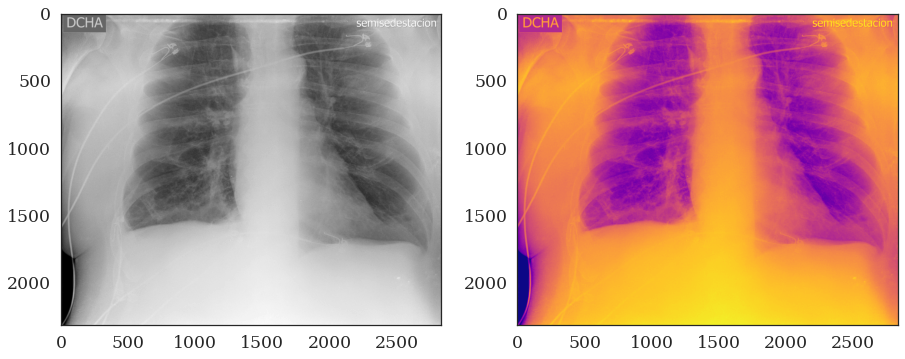

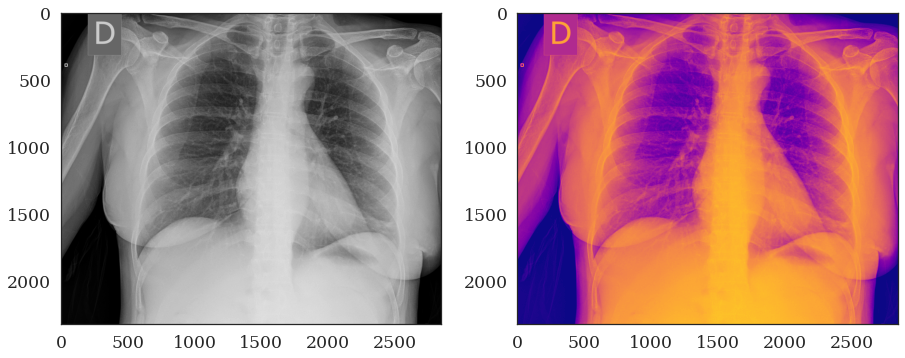

Typical Appearance


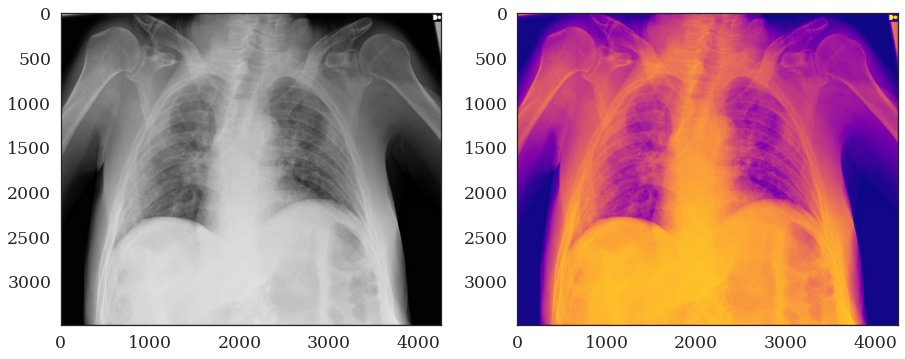

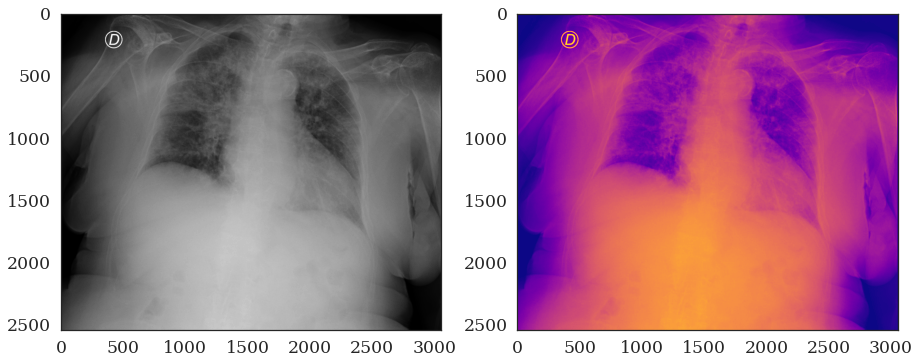

Indeterminate Appearance


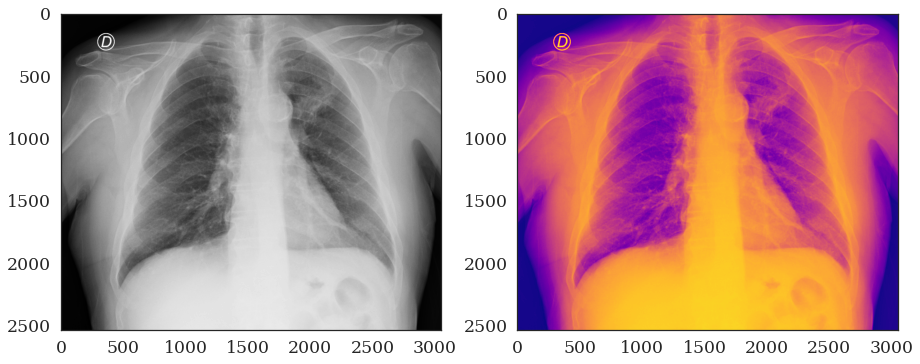

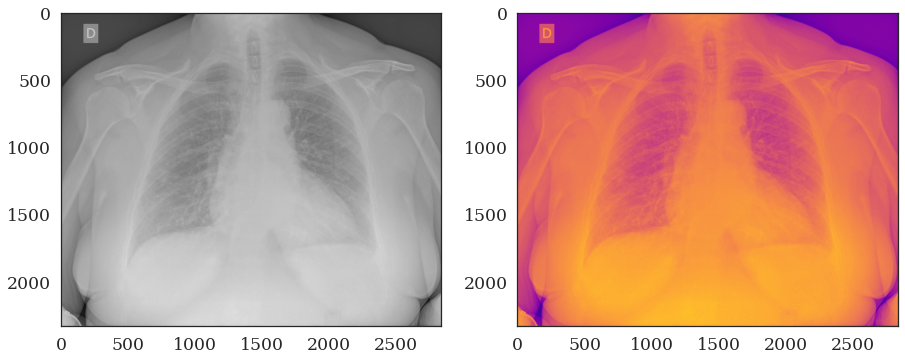

Atypical Appearance


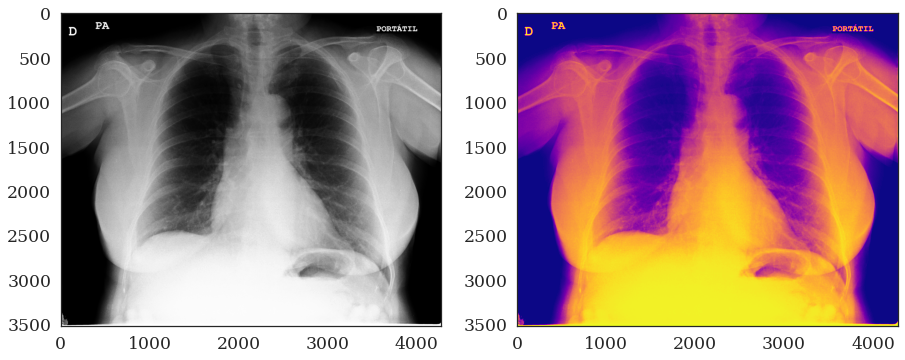

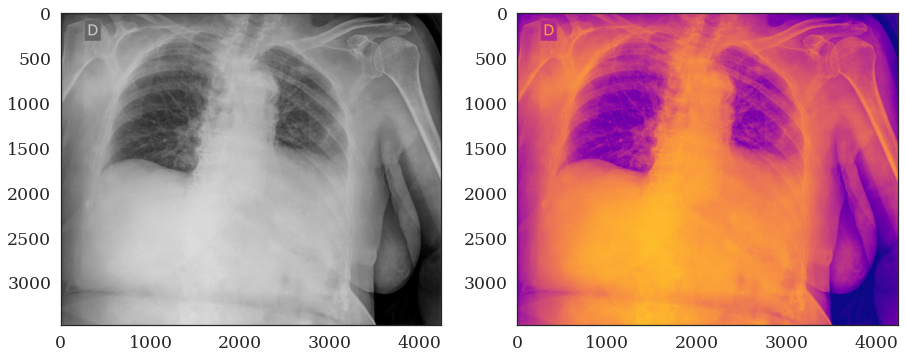

In [48]:
# initializing the run
run = wandb.init(project="siim",
                 job_type="upload"
                 )

# creating an artifact 
artifact = wandb.Artifact(name="dicom_images", type="raw_data")

# setting up a WandB Table object to hold the dataset
columns=["dicom image", "class"]

table = wandb.Table(
    columns=columns
)

classes = ['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
for siim_class in classes:
    print(siim_class)
    for _, row in train_df[train_df[siim_class]==1].iloc[:2].iterrows():
        filename = row['path']
        df, img_array = dicom_dataset_to_dict(filename,'fetch_both_values')
        
        fig, ax = plt.subplots(1, 2, figsize=[15, 8])
        ax[0].imshow(img_array, cmap=plt.cm.gray)
        ax[1].imshow(img_array, cmap=plt.cm.plasma)   
        plt.show()
        
        img_object = Image.fromarray(img_array)
        
        # raw image
        raw_img = wandb.Image(img_object)

        # adding a row to the table
        row = [raw_img,siim_class]
        table.add_data(*row)
        
# adding the table to the artifact
artifact.add(table, "raw_examples")
    
# logging the artifact
run.log_artifact(artifact)

run.finish()

In [49]:
train_jpg_directory = '/content/Input/siim/train'
test_jpg_directory = '/content/Input/siim/test'

def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

train_images_path = getImagePaths(train_jpg_directory)
test_images_path = getImagePaths(test_jpg_directory)

print(f"{y_}Number of train images: {g_} {len(train_images_path)}\n")
print(f"{y_}Number of test images: {g_} {len(test_images_path)}\n")

def getShape(data, images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return data +" - Different image shape"
        else:
            return data +" - Same image shape " + str(shape)

Number of train images:  6334

Number of test images:  1263



In [51]:
run = wandb.init(project='siim', name='count')

wandb.log({'Training samples': len(train_images_path) , 
           'Test samples': len(test_images_path) 
          })

run.finish()

In [ ]:
def getShape(data, images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return data +" - Different image shape"
        else:
            return data +" - Same image shape " + str(shape)

In [54]:
getShape('train',train_images_path)

AttributeError: ignored

In [ ]:
getShape('test',test_images_path)

In [ ]:
def plot_augmentations(images, titles, sup_title):
    fig, axes = plt.subplots(figsize=(20, 16), nrows=3, ncols=4, squeeze=False)
    
    for indx, (img, title) in enumerate(zip(images, titles)):
        axes[indx // 4][indx % 4].imshow(img)
        axes[indx // 4][indx % 4].set_title(title, fontsize=15)
        
    plt.tight_layout()
    fig.suptitle(sup_title, fontsize = 20)
    fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)
    plt.show()
    
def augment(paths, data):
    
    # list of albumentations
    albumentations = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                              A.RandomCrop(p=1,height = 128, width = 128), A.Rotate(p=1, limit=90),
                              A.RGBShift(p=1), A.RandomSnow(p=1),
                              A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1),
                              A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]
    
    # image titles
    titles = ["RandomSunFlare","RandomFog","RandomBrightness",
                       "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]
    
    for i in paths:
        image_path = i
        
        # getting image name from path
        image_name = image_path.split("/")[4].split(".")[0]
        
        # reading image
        image = cv2.imread(image_path)

        # list of images
        images = []
        
        # creating image augmentations
        for augmentation_type in albumentations:
            augmented_img = augmentation_type(image = image)['image']
            images.append(augmented_img)

        # original image
        titles.insert(0, "Original")
        images.insert(0,image)  
        
        sup_title = "Image Augmentation for " + data + " - " + image_name
        plot_augmentations(images, titles, sup_title)
        
        titles.remove("Original")

In [53]:
augment(train_images_path[0:2],'train')

NameError: ignored

In [ ]:
augment(train_images_path[0:2],'test')